# Quickstart

This notebook shows how to train and validate a model with ScAPE and how to do predictions for cell/drug combinations

In [1]:
# Disable all warnings
import scape
import pandas as pd
import matplotlib.pyplot as plt

scape.__version__

'0.1.0'

In [2]:
df_de = scape.io.load_slogpvals("_data/de_train.parquet")
df_lfc = scape.io.load_lfc("_data/lfc_train.parquet")

# Make sure rows/columns are in the same order
df_lfc = df_lfc.loc[df_de.index, df_de.columns]
df_de.shape, df_lfc.shape

((614, 18211), (614, 18211))

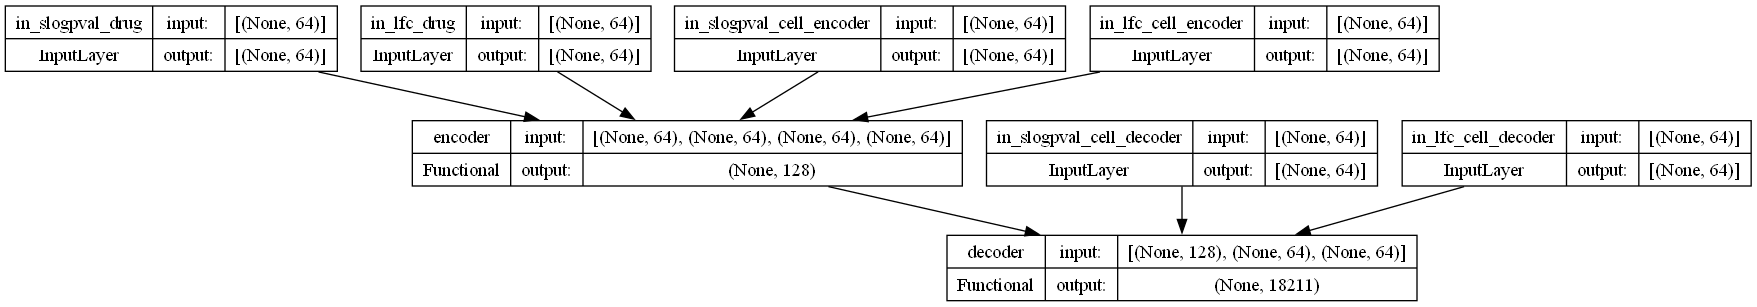

In [3]:
# We select only a subset of the genes for the model (top most variant genes)
n_genes = 64
top_genes = scape.util.select_top_variable([df_de], k=n_genes)

# Data sources point to the dataframes with the data from which the features are extracted
data_sources = {
    'slogpval': df_de,
    'lfc_pseudo': df_lfc
}

# Define the way in which the features are extracted from the data sources
feature_extraction = {
    'slogpval_drug': {
        'source': 'slogpval',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'lfc_drug': {
        'source': 'lfc_pseudo',
        'groupby': 'sm_name',
        'function': 'median'
    },
    'slogpval_cell': {
        'source': 'slogpval',
        'groupby': 'cell_type',
        'function': 'median'
    },
    'lfc_cell': {
        'source': 'lfc_pseudo',
        'groupby': 'cell_type',
        'function': 'median'
    }
}

# Names of the input layers -> feature extraction method
input_mapping = {
    'in_slogpval_drug': 'slogpval_drug',
    'in_lfc_drug': 'lfc_drug',
    'in_slogpval_cell_encoder': 'slogpval_cell',
    'in_lfc_cell_encoder': 'lfc_cell',
    'in_slogpval_cell_decoder': 'slogpval_cell',
    'in_lfc_cell_decoder': 'lfc_cell',
}

# Configuration for the NN architecture
config = {
    "inputs": {
        "in_slogpval_drug"          : [n_genes, 256, 128],
        "in_lfc_drug"               : [n_genes, 256, 128],
    },
    "conditional_encoder_input_structure": {
        "in_slogpval_cell_encoder"  : [n_genes, 32],
        "in_lfc_cell_encoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_structure": {
        "in_slogpval_cell_decoder"  : [n_genes, 32],
        "in_lfc_cell_decoder"       : [n_genes, 32, 16],
    },
    "conditional_decoder_input_hidden_sizes": [32],
    "encoder_hidden_layer_sizes": [128, 128],
    "decoder_hidden_layer_sizes": [128, 512],
    "outputs": {
        "logpval": (df_de.shape[1], "linear"), 
    },
    # Layer config
    "noise": 0.01,
    "dropout": 0.05,
    "l1": 0,
    "l2": 0
}

model_setup = {
    "data_sources": data_sources,
    "feature_extraction": feature_extraction,
    "input_mapping": input_mapping,
    "output_genes": df_de.columns,
    "config": config
}

# Create model
scm = scape.SCAPE(model_setup)
scape.util.plot(scm.model, show_shapes=True)

In [4]:
scm.model.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_slogpval_drug (InputLay  [(None, 64)]                 0         []                            
 er)                                                                                              
                                                                                                  
 in_lfc_drug (InputLayer)    [(None, 64)]                 0         []                            
                                                                                                  
 in_slogpval_cell_encoder (  [(None, 64)]                 0         []                            
 InputLayer)                                                                                      
                                                                                        

In [5]:
result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=300,
    baselines=["zero", "slogpval_drug"]
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']

Epoch    1: val_loss None -> 1.4151, train loss: 1.3068 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0086, 0.85%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7969, -25.48%
Epoch    2: val_loss 1.4151 -> 1.3815, train loss: 1.2771 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0332, 3.21%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8164, -22.50%
Epoch    3: val_loss 1.3815 -> 1.3536, train loss: 1.2502 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0545, 5.16%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8332, -20.02%
Epoch    5: val_loss 1.3536 -> 1.3477, tra

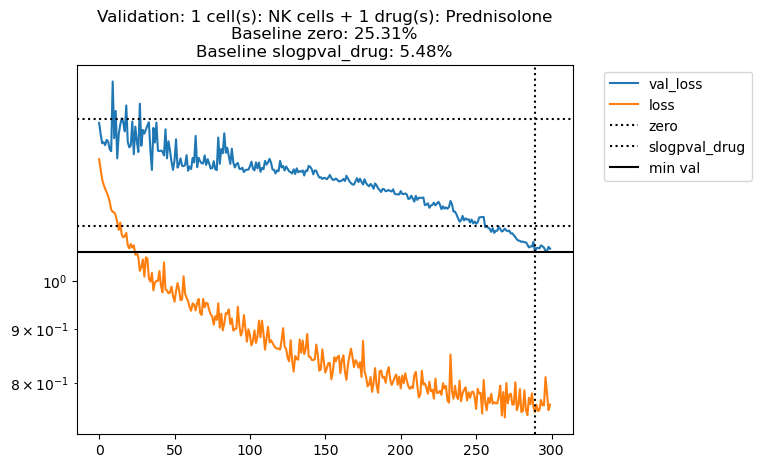

In [6]:
scape.util.plot_result(result, legend=True)

## Inference

In [7]:
# Predict using a given dataframe index
scm.predict(df_de)

20/20 [==============================] - 1s 10ms/step


,,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
cell_type,sm_name,,,,,,,,,,,,,,,,,,,,,
NK cells,Clotrimazole,0.194414,0.157227,-0.070179,0.009600,0.114648,0.338328,0.076248,0.163527,-0.140055,0.244689,...,0.042096,-0.158234,-0.059915,-0.039544,-0.019006,0.054201,0.150999,0.103660,0.112037,0.037434
T cells CD4+,Clotrimazole,0.009779,-0.097105,0.083260,-0.057180,0.010844,0.243668,-0.184838,0.089963,-0.065037,0.227762,...,-0.202045,0.087562,0.036073,-0.092795,0.300995,-0.067515,0.244625,0.075626,0.144302,-0.069032
T cells CD8+,Clotrimazole,-0.163914,-0.397257,-0.268933,-0.070648,-0.159012,-0.464534,-0.134033,-0.198160,-0.365885,0.217887,...,0.014628,-0.370442,-0.360676,-0.486203,0.011065,-0.289772,0.052777,-0.105549,-0.061072,-0.138286
T regulatory cells,Clotrimazole,0.260759,0.264802,0.388628,0.572786,0.525528,0.398779,-0.064918,0.303745,-0.179417,0.211233,...,-0.056566,0.295044,-0.019873,0.166435,0.413039,0.433954,0.356801,0.264965,-0.105367,-0.027750
NK cells,Mometasone Furoate,0.761197,0.099600,-0.487814,-0.304756,0.068401,2.010531,0.526351,0.679624,-0.004084,1.631494,...,-0.116993,-0.314878,0.472689,0.101642,0.101359,0.426433,0.040792,0.540312,-1.149533,0.273278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T regulatory cells,Atorvastatin,-0.090314,-0.416945,-0.410972,-0.486288,-0.504089,-0.313944,-0.096291,-0.650317,-0.118002,-0.001408,...,-0.279535,-0.523046,-0.400566,-0.560992,-0.406564,-0.144007,-0.370364,-0.139863,0.039296,-0.442674
NK cells,Riociguat,0.041222,0.170445,-0.020082,-0.026019,0.041145,0.196462,-0.011627,0.164335,-0.200379,0.124760,...,0.128824,-0.045591,-0.197567,-0.049303,-0.030546,0.008790,0.130760,0.022545,0.074422,-0.059573
T cells CD4+,Riociguat,0.027641,0.020953,0.023018,-0.161994,-0.205585,0.018626,-0.115283,0.071414,-0.018889,0.036839,...,-0.069316,0.099511,-0.087466,0.044207,0.243455,0.023825,0.109964,-0.047073,0.138471,-0.097747


In [8]:
# Predict from a given multi-index
scm.predict(
    pd.MultiIndex.from_tuples([
        ("NK cells", "Bosutinib"),
        ("NK cells", "Belinostat"),
        ("Myeloid cells", "Bosutinib"),
        ("Myeloid cells", "Belinostat"),
    ], names=["cell_type", "sm_name"])
)

1/1 [==============================] - 0s 100ms/step


A1BG  A1BG-AS1       A2M    A2M-AS1      A2MP1  \
cell_type     sm_name                                                          
NK cells      Bosutinib   0.330316  0.138537 -0.154608  -0.042543   0.235437   
              Belinostat  1.666431  3.450031 -8.108703 -16.189913  -3.965121   
Myeloid cells Bosutinib   0.599696  0.033600 -0.592653   0.107676   4.732639   
              Belinostat  3.609646  2.358377 -8.683269   0.118509  15.380356   

                            A4GALT      AAAS      AACS     AAGAB      AAK1  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.781162  0.114396  0.222130 -0.071732  0.424109   
              Belinostat  6.956760  0.939568  0.900427  4.964502  4.974038   
Myeloid cells Bosutinib   2.272205  0.204302 -0.048383  0.280770  0.398841   
              Belinostat  6.253202  1.260448 -1.412510  2.200832  4.408970   

                          ...      ZUP1      ZW10    ZWILCH     ZWINT  \
cell_type     sm_name     ...                                           
NK cells      Bosutinib   ... -0.011349 -0.301028  0.034625 -0.008219   
              Belinostat  ...  5.483314  1.852388 -2.629870  0.311158   
Myeloid cells Bosutinib   ... -1.014911 -0.452582 -0.257989 -0.887243   
              Belinostat  ...  2.190039 -0.478366 -5.948822 -1.081164   

                              ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
cell_type     sm_name                                                        
NK cells      Bosutinib   0.021145  0.125907  0.192161  0.209567  0.025681   
              Belinostat -1.745673  0.308468 -0.960009  4.471121 -0.727347   
Myeloid cells Bosutinib   1.013566 -0.028484  0.012789  0.156828 -0.152137   
              Belinostat  1.773736 -0.035427 -3.334975  0.998982  2.543381   

                             ZZEF1  
cell_type     sm_name               
NK cells      Bosutinib   0.078541  
              Belinostat -1.623647  
Myeloid cells Bosutinib   0.071150  
              Belinostat -0.463846  

[4 rows x 18211 columns]

In [9]:
# Predict from tuples
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 [==============================] - 0s 89ms/step


A1BG  A1BG-AS1       A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                         
NK cells  Bosutinib   0.330316  0.138537 -0.154608  -0.042543  0.235437   
          Belinostat  1.666431  3.450031 -8.108703 -16.189913 -3.965121   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.781162  0.114396  0.222130 -0.071732  0.424109  ...   
          Belinostat  6.956760  0.939568  0.900427  4.964502  4.974038  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib  -0.011349 -0.301028  0.034625 -0.008219  0.021145   
          Belinostat  5.483314  1.852388 -2.629870  0.311158 -1.745673   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.125907  0.192161  0.209567  0.025681  0.078541  
          Belinostat  0.308468 -0.960009  4.471121 -0.727347 -1.623647  

[2 rows x 18211 columns]

1/1 [==============================] - 0s 71ms/step


<Axes: xlabel='y', ylabel='y_pred'>

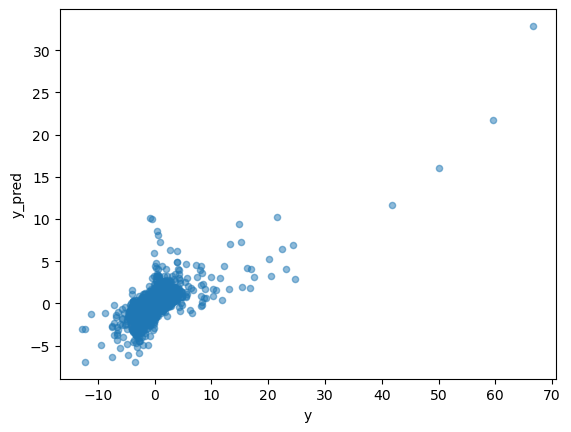

In [10]:
# Plot correlation between predicted and observed values
df_cmp = pd.DataFrame({
    'y': df_de.loc[("NK cells", "Prednisolone")].values.ravel(), 
    'y_pred': scm.predict([("NK cells", "Prednisolone")]).values.ravel()
})

# Make the plot square with same X and Y limits
df_cmp.plot.scatter(x='y', y='y_pred', alpha=0.5)

In [11]:
# Save model
scm.save("_models/config.pkl", "_models/weights.keras", "_models/result.pkl")

In [12]:
scm = scape.SCAPE.load("_models/config.pkl", "_models/weights.keras", "_models/result.pkl")
scm.predict([("NK cells", "Bosutinib"), ("NK cells", "Belinostat")])

1/1 [==============================] - 2s 2s/step


A1BG  A1BG-AS1       A2M    A2M-AS1     A2MP1  \
cell_type sm_name                                                         
NK cells  Bosutinib   0.330316  0.138537 -0.154608  -0.042543  0.235437   
          Belinostat  1.666431  3.450031 -8.108703 -16.189913 -3.965121   

                        A4GALT      AAAS      AACS     AAGAB      AAK1  ...  \
cell_type sm_name                                                       ...   
NK cells  Bosutinib   0.781162  0.114396  0.222130 -0.071732  0.424109  ...   
          Belinostat  6.956760  0.939568  0.900427  4.964502  4.974038  ...   

                          ZUP1      ZW10    ZWILCH     ZWINT      ZXDA  \
cell_type sm_name                                                        
NK cells  Bosutinib  -0.011349 -0.301028  0.034625 -0.008219  0.021145   
          Belinostat  5.483314  1.852388 -2.629870  0.311158 -1.745673   

                          ZXDB      ZXDC    ZYG11B       ZYX     ZZEF1  
cell_type sm_name                                                       
NK cells  Bosutinib   0.125907  0.192161  0.209567  0.025681  0.078541  
          Belinostat  0.308468 -0.960009  4.471121 -0.727347 -1.623647  

[2 rows x 18211 columns]

## Save during training

In [13]:
scm = scape.SCAPE(model_setup)

result = scm.train(
    val_cells=["NK cells"], 
    val_drugs=["Prednisolone"],
    input_columns=top_genes,
    epochs=30,
    baselines=["zero", "slogpval_drug"],
    output_folder="_models",
    config_file_name="example_config.pkl",
    model_file_name=f"example_model.keras",
    result_file_name="example_result.pkl"
)

Baseline zero MRRMSE: 1.4273
Baseline slogpval_drug MRRMSE: 1.1278
Model size (MB): 36.76
Model inputs: ['in_slogpval_drug', 'in_lfc_drug', 'in_slogpval_cell_encoder', 'in_lfc_cell_encoder', 'in_slogpval_cell_decoder', 'in_lfc_cell_decoder']
Model will be saved to _models\example_model.keras
Epoch    1: val_loss None -> 1.4205, train loss: 1.3073 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0048, 0.47%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.7939, -25.96%
Epoch    2: val_loss 1.4205 -> 1.3863, train loss: 1.2798 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0295, 2.87%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8135, -22.92%
Epoch    3: val_loss 1.3863 -> 1.3620, train loss: 1.2507 (lr=0.00500)
	 > Improvement factor/percentage zero                 (err=1.4273): 1.0479, 4.57%
	 > Improvement factor/percentage slogpval_drug        (err=1.1278): 0.8280, 

In [14]:
# Check that the error is the same
scm = scape.model.SCAPE.load( "_models/example_config.pkl", "_models/example_model.keras", "_models/example_result.pkl")

y_true = df_de.loc[(df_de.index.get_level_values("cell_type") == "NK cells") & (df_de.index.get_level_values("sm_name") == "Prednisolone")]
y_pred = scm.predict([("NK cells", "Prednisolone")])

scape.losses.np_mrrmse(y_true, y_pred)

1/1 [==============================] - 1s 633ms/step


1.2916558015647297